# Proyecto Intermedio
Puede ver el código original en el siguiente link: https://colab.research.google.com/drive/1PkG5bumzrGjhSmWLMduk5xUQzmxjUUUE?usp=sharing

# 0. Importar librerías necesarias y definir funciones de apoyo

In [51]:
# Importando librerías
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops_table, regionprops
from skimage.feature import canny
import pandas as pd

In [88]:
# Definir funciones útiles
def show_img(img, figsize = (5, 5), **kwargs):
    fig, axs = plt.subplots(figsize = figsize)
    plt.imshow(img, **kwargs)
    plt.axis('off')

    return axs

def normalize(img):
    min_value = np.min(img)
    max_value = np.max(img)
    return (img - min_value) / (max_value - min_value) 


# Genera imagenes binarias
def binarize(img, max_val):
	return (img >= max_val) * 255

# Transformación Negativa
def imcomplement(img):
	return np.abs(255 - img)


# Mostrar varias imágenes
def show_imgs_row(imgs, size = (7,7), is_gray = True, info = False, titles = None, is_double = False, max_pixels = 255):
    schema = (1, len(imgs))
    options = {}
    if is_gray:
        options["cmap"] = "gray"
        options["vmin"] = 0

    fig, axs = plt.subplots(*schema, figsize=size)

    for index in range(len(imgs)):
        vmax = 1 if is_double and is_double[index] else max_pixels
        axs[index].imshow(imgs[index], vmax = vmax, **options)
        axs[index].axis("off")
        if titles:
            axs[index].set_title(titles[index])

def normalize_img(img, norm_factor = 1):
	if (np.max(img) - np.min(img)) != 0:
		return (img - np.min(img)) / (np.max(img) - np.min(img)) * norm_factor
	
	return img / np.max(img)

## 0.5 Leer la imagen

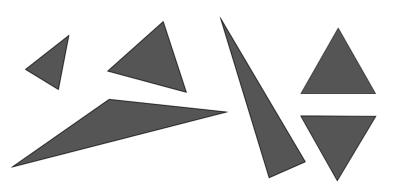

(365, 805)

In [70]:
# Leer imagen
triangles = cv2.imread("Triangulos.PNG", cv2.IMREAD_GRAYSCALE)
# Mostrar
show_img(triangles, cmap = "gray")
plt.show()
triangles.shape

## 1. (2 puntos) Segmentar los triángulos de la imagen, calcule el área y el centroide para cada triángulo. Haga una tabla con esta información.

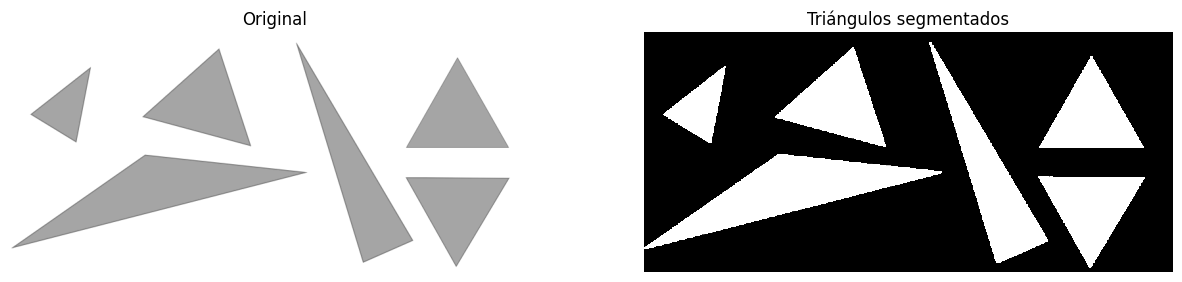

In [71]:
# Para segmentarlos podriamos solamente hacer una imagen binaria y 
bw_triangles = imcomplement(binarize(triangles, 255))
show_imgs_row([triangles, bw_triangles], titles = ['Original', 'Triángulos segmentados'], is_double = [False, True], size = (15, 15))

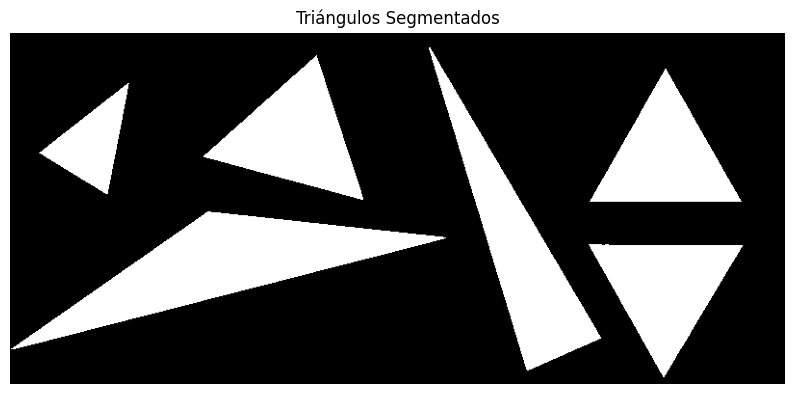

In [87]:
# Estas lineas de código son solo para guardar la imagen individual y ponerla en los resultados
plt.subplots(figsize = (10, 10))
plt.imshow(bw_triangles, cmap = "gray")
plt.axis('off')
plt.title('Triángulos Segmentados')
plt.savefig('triangulos_segmentados.png', bbox_inches='tight', pad_inches=0)

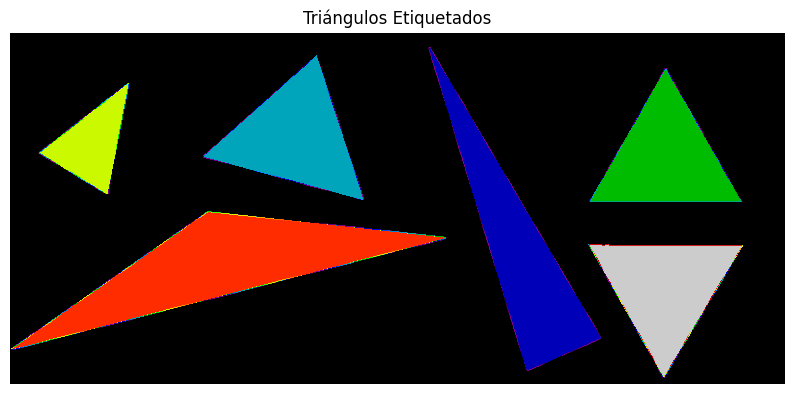

Triangulos en la imagen según este algoritmo = 6


In [79]:
# Usar el label que es muy parecido a bwlabel, en lugar de 8 aca es 2
labels_triangles = label(bw_triangles, connectivity = 2)

# Calcular el total de etiquetas (el total de triangulos)
n_triangles = labels_triangles.max()

# Desplegar imagen
show_img(labels_triangles, cmap = "nipy_spectral", figsize = (10, 10)) # nipy_spectral
plt.title('Triángulos Etiquetados')
plt.savefig("triangulos_etiquetados.png")
plt.show()

print(f"Triangulos en la imagen según este algoritmo = {n_triangles}")

In [80]:
# Ahora a sacar las propiedades de estos triangulos
properties = regionprops_table(labels_triangles, properties=('area', 'centroid'))
properties # Esto no tiene un formato de tabla como la queremos

{'area': array([15013, 11491, 10936,  4664, 20913, 11042]),
 'centroid-0': array([225.92359955, 108.80802367, 129.33046818, 114.91359348,
        242.73351504, 266.33064662]),
 'centroid-1': array([527.57536801, 295.00974676, 680.5       ,  84.635506  ,
        219.63687658, 679.99411339])}

In [81]:
# Transformemos a pandas y desplegando
stats_triangles = pd.DataFrame(properties)
stats_triangles.columns = ["area", "centroid_row", "centroid_col"]

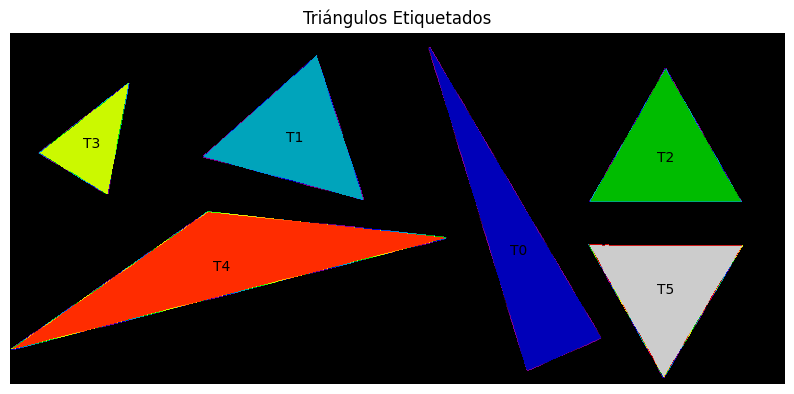

In [84]:
# Con estos centroides podemos identificar a cada uno de los triangulos
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(labels_triangles, cmap = 'nipy_spectral')
ax.set_title('Triángulos Etiquetados')
ax.axis('off')

# Cada número estará en el centroide de cada triángulo
for index, row in stats_triangles.iterrows():
    centroid = (row['centroid_col'], row['centroid_row'])
    ax.text(*centroid, str(index), color='black', ha='center', va='center')

plt.title('Triángulos Etiquetados')
plt.savefig("triangulos_etiquetados.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [83]:
# Imprimir la tabla de propiedades
new_index = [f"T{i}" for i in range(len(stats_triangles))]
stats_triangles = stats_triangles.rename(index = dict(zip(stats_triangles.index, new_index)))
stats_triangles.to_excel("propiedades_triangulos.xlsx")
stats_triangles # Note que el area está en pixeles

,area,centroid_row,centroid_col
T0,15013,225.923600,527.575368
T1,11491,108.808024,295.009747
T2,10936,129.330468,680.500000
T3,4664,114.913593,84.635506
T4,20913,242.733515,219.636877
T5,11042,266.330647,679.994113


## 2. (2 puntos) Segmentar las aristas de cada triángulo. En los resultados mostrar la imagen donde se pinten las aristas encontradas

In [89]:
# Para detectar edges usamos la función canny de skimage, pero primero tenemos que normalizar la imagen
bw_norm = normalize_img(bw_triangles)
# Detectar edges
edges = canny(bw_norm)

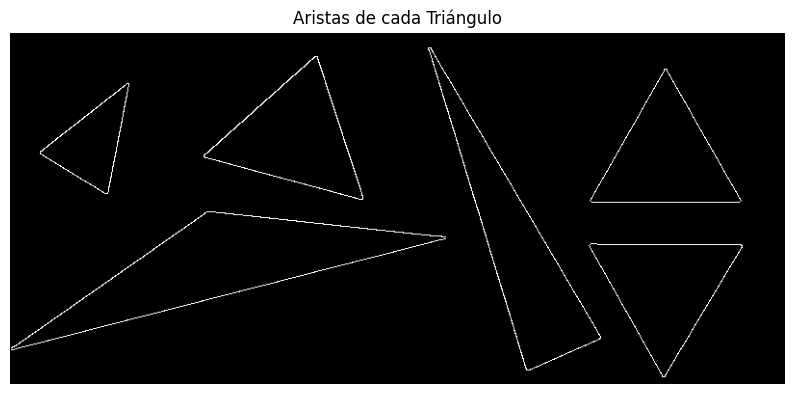

In [92]:
# Graficar y guardar esta nueva imagen
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(edges, cmap = 'gray')
ax.set_title('Aristas de cada Triángulo')
ax.axis('off')
plt.savefig('triangulos_aristas.png', bbox_inches='tight', pad_inches=0)
plt.show()

## 3. (2 puntos) Encontrar los modelos de los segmentos de rectas que forman cada arista y para cada triángulo. Los parámetros que debe encontrar de cada arista son: θ, ρ, longitud. Hacer una tabla donde cada renglón sea una arista (identifíquelas con un número) y las columnas sean los parámetros indicados.

In [93]:
# Más imports
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line

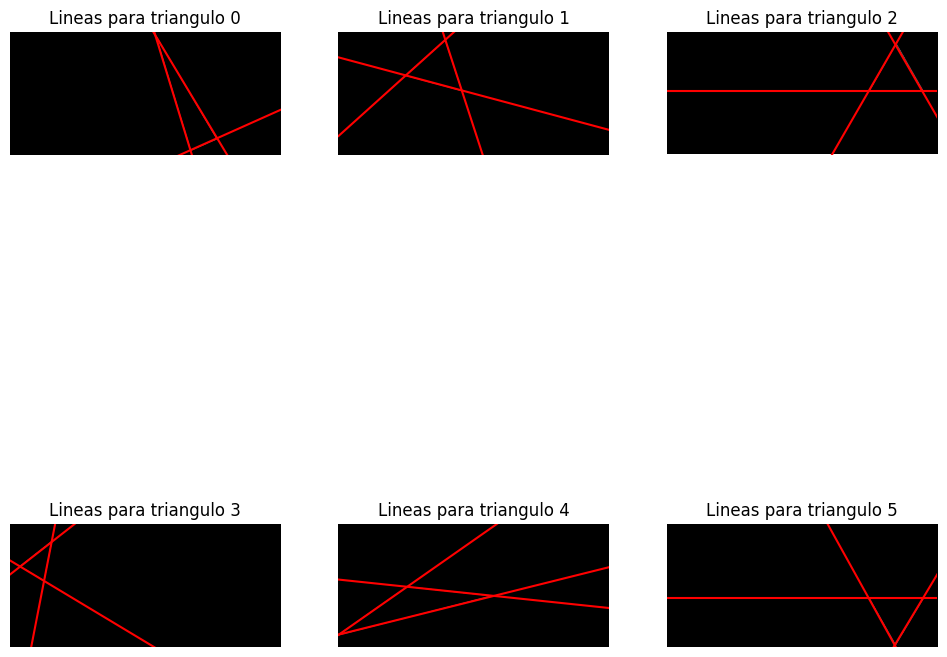

In [94]:
# Para cada triangulo tenemos que hacer un análisis, para diferenciar entre triángulos podemos usar regionprops de python
properties = regionprops((labels_triangles))
edges_data = []

# Ahora analizar cada triángulo por separado
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
# Ajustes
plt.tight_layout()
i, j = 0, 0
for index, prop in enumerate(properties):
    # Obtenemos coordenadas del triangulo y la plasmamos sobre una imagen
    coords = prop.coords
    triangle_image = np.zeros_like(labels_triangles)
    triangle_image[coords[:, 0], coords[:, 1]] = 1
    

    # Detectando las aristas de nuevo (porque regionprops no acepta edges de una)
    triangle_edges = canny(triangle_image, low_threshold = 0.1, high_threshold=0.1)

    # Algo raro pasa con el primer triangulo así que lo arreglaré a mano
    # Los valores de angle y dist para este caso fueron calculados a partir de aproximaciones visuales con prueba y error.
    if not index:
        edges_data.append([f"T{index}", 1.15, np.degrees(1.15), 540])
        rows, cols = triangle_edges.shape
        y0 = (540 - 0 * np.cos(1.15)) / np.sin(1.15)
        y1 = (540 - cols * np.cos(1.15)) / np.sin(1.15)
        ax[0][0].plot((0, cols), (y0, y1), '-r')


    # Transformación de Hough ---------------------------------------->
    h_space, h_angles, h_dists = hough_line(triangle_edges)
    rows, cols = triangle_edges.shape
    # Podemos visualizarlo así
    counter = 0
    for _, angle, dist in zip(*hough_line_peaks(h_space, h_angles, h_dists)):
        if counter > 2:
            break

        edges_data.append([f"T{index}", angle, np.degrees(angle), dist])
        if angle == 0:
            continue
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
        ax[i][j].plot((0, cols), (y0, y1), '-r')

        counter += 1

            
    ax[i][j].set_title(f'Lineas para triangulo {index}')
    ax[i][j].set_axis_off()

    ax[i][j].imshow(triangle_edges, cmap = 'gray')

    j += 1
    if j == 3:
        i += 1
        j = 0
# Guardamos
plt.savefig("lineas_por_triangulo.png", bbox_inches='tight', pad_inches=0)
# Transformamos a un df
edges_df = pd.DataFrame(edges_data, columns=['Triangle', 'Theta', 'Theta (Grados)', 'Rho'])

In [95]:
# Cambiamos los índices por default a los nombres que pide el documento
new_index = [f"A{i+1}" for i in range(len(edges_df))]
edges_df = edges_df.rename(index = dict(zip(edges_df.index, new_index)))

In [96]:
# Para obtener la longitud de las líneas hay que obtener las intersecciones entre ellas, estos son los vertices 
from sympy import symbols, Eq, solve

# Define los símbolos para la resolución de las ecuaciones
x, y = symbols('x y')

# Lista para almacenar los datos de los lados de los triángulos
vertices = []

# Por cada triángulo
for i in range(0, 6):
    # Obtiene las líneas del triángulo actual
    triangle_lines = edges_df[edges_df['Triangle'] == f"T{i}"]

    # Para cada par de líneas
    for j in range(3):
        for k in range(j+1, 3):
            # Obtiene los parámetros de las dos líneas
            theta1, rho1 = triangle_lines.iloc[j, 1], triangle_lines.iloc[j, 3]
            theta2, rho2 = triangle_lines.iloc[k, 1], triangle_lines.iloc[k, 3]

            # Define las ecuaciones de las líneas
            eq1 = Eq(x*np.cos(theta1) + y*np.sin(theta1), rho1)
            eq2 = Eq(x*np.cos(theta2) + y*np.sin(theta2), rho2)

            # Resuelve las ecuaciones para encontrar el punto de intersección
            sol = solve((eq1, eq2), (x, y))
            sol_x, sol_y = float(sol[x]), float(sol[y])

            vertices.append([f"T{i}", sol_x, sol_y])

# Transforma a un DataFrame
vertices_df = pd.DataFrame(vertices, columns=['Triangle', 'x', 'y'])

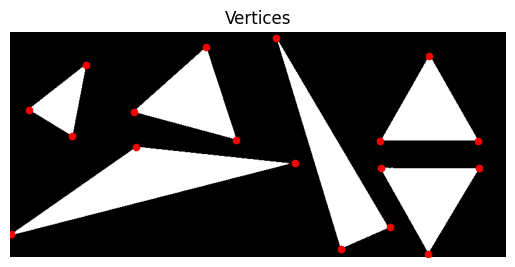

In [97]:
# Mostramos los vertices
plt.scatter(vertices_df["x"], vertices_df["y"], c="red", s=20)
plt.imshow(bw_norm, cmap = "gray")
plt.title("Vertices")
plt.axis("off")
plt.savefig("vertices.png", bbox_inches = "tight", pad_inches = 0)
plt.show()

In [98]:
# Calculamos las distancias para cada uno de los vertices
distances_data = []
# distances_data = []
for n_triangle in range(0, 6):
    triangles_data = vertices_df[vertices_df["Triangle"] == f"T{n_triangle}"].to_numpy()

    for i in range(3):
        for j in range(i + 1, 3):
            x1, y1 = triangles_data[i][1], triangles_data[i][2]
            x2, y2 = triangles_data[j][1], triangles_data[j][2]
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            distances_data.append(dist)
edges_df["Longitud"] = distances_data

### Mostrar resultados

In [99]:
# Guardar
edges_df.to_excel("lineas_triangulos.xlsx")
edges_df

,Triangle,Theta,Theta (Grados),Rho,Longitud
A1,T0,1.150000,65.890146,540.0,87.085975
A2,T0,-0.296706,-17.000000,410.0,357.375832
A3,T0,-0.541052,-31.000000,365.0,357.207608
A4,T1,-1.308997,-75.000000,-73.0,172.317123
A5,T1,0.837758,48.000000,230.0,158.193878
A6,T1,-0.314159,-18.000000,295.0,158.193878
A7,T2,-1.570796,-90.000000,-176.0,159.348674
A8,T2,0.523599,30.000000,608.0,159.348674
A9,T2,-0.523599,-30.000000,570.0,159.348674
A10,T3,0.191986,11.000000,131.0,117.945106


## 4. (2 puntos) Ahora elija del conjunto de segmentos de rectas aquellas que forman cada triangulo, haga una tabla donde haya 3 columnas, cada una con el número de segmento de recta (del inciso 3) que forman un triángulo, los renglones representan a cada triángulo. (ejemplo, supongamos que las aristas A1, A2 y A3 forman al triángulo T1 y las aristsa A8, A17 y A18 forman al triángulo T6, entonces la tabla quedará de la siguiente manera:

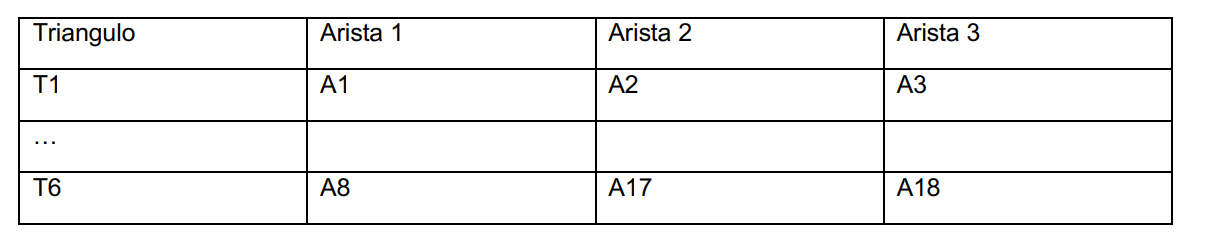

In [100]:
# Hagamos la tabla, tome en cuenta que en mi caso están en orden, por lo tanto se verá distinto al del ejemplo
edges = list(edges_df['Triangle'].keys())
t_names = list(edges_df['Triangle'].values)

In [101]:
data={"Triangulo": t_names, "Arista": edges}
# Create DataFrame
new_table = pd.DataFrame(data)

# Pivotar la tabla
new_table = pd.pivot_table(new_table, index='Triangulo', columns=new_table.groupby('Triangulo').cumcount() + 1, values='Arista', aggfunc='first')

# Cambiar el nombre de las columnas
new_table.columns = ['Arista ' + str(col) for col in new_table.columns]

# Guardar
new_table.to_excel("relacion_triangulo_aristas.xlsx")
new_table

,Arista 1,Arista 2,Arista 3
Triangulo,,,
T0,A1,A2,A3
T1,A4,A5,A6
T2,A7,A8,A9
T3,A10,A11,A12
T4,A13,A14,A15
T5,A16,A17,A18


## 5. (2 puntos) Encontrar las aristas que son paralelas entre triángulos diferentes. Reporte cuantos grupos de aristas paralelas encontró e indique como están conformados estos grupos.

En este caso parece que solo hay dos líneas EXACTAMENTE paralelas, una del triángulo 2 y una del triángulo 5, sin embargo, parece ser que si nos ponemos menos exigentes y en lugar de requerir que los ángulos sean exactamente iguales, añadimos un pequeño márgen de error (debido a que los métodos que utilizamos tienen fallas o errores pequeños). Pondremos un error de 5 grados.

In [102]:
# Redondeemos los decimales para empezar
edges_df['Theta (Grados)'] = edges_df['Theta (Grados)'].round()

In [103]:
# Hare una funcion
def count_paralel_with_error(column, error = 5):
    degrees = list(column.values)
    arists = list(column.index)

    paralels = {}

    # Por desgracia no hay manera de hacer esto sin nested-fors
    for i in range(len(degrees)):
        for j in range(i + 1, len(degrees)):
            if abs(degrees[i] - degrees[j]) <= error:
                rounded = np.round(degrees[i], -int(np.floor(np.log10(np.abs(degrees[i])))))
                if rounded not in paralels:
                    paralels[rounded] = [arists[i]]
                if arists[j] not in paralels[rounded]:
                    paralels[rounded].append(arists[j])

    return dict(paralels)


In [104]:
# Creamos la tabla de rectas paralelas
paralels = count_paralel_with_error(edges_df['Theta (Grados)'])
paralels_df = pd.DataFrame.from_dict(paralels, orient = 'index')
paralels_df.columns = ["Arista 1", "Arista 2", "Arista 3"]
paralels_df.index.name = "Grado (aprox)"
paralels_df = paralels_df.fillna("")

In [110]:
print(f"Encontré {len(paralels)} grupos de líneas paralelas (con un margen de 5 grados) conformadas por:")
paralels_df.to_excel("lineas_paralelas.xlsx")
paralels_df

Encontré 5 grupos de líneas paralelas (con un margen de 5 grados) conformadas por:


,Arista 1,Arista 2,Arista 3
Grado (aprox),,,
-20.0,A2,A6,
-30.0,A3,A9,A18
50.0,A5,A11,A14
-90.0,A7,A16,
30.0,A8,A17,


# Preguntas

## 1. Conociendo la ecuación de las rectas y la longitud de los segmentos que forman cada arista de los triángulos, ¿se puede calcular el área del triángulo? De ser cierta la aseveración, ¿el área coincide con lo encontrado en el objetivo 1?

Sí, de hecho esto se hace con la fórmula de heron, primero tenemos que calcular el semiperimetro

$semiperimetro = (a + b + c) / 2$

Después de eso aplicar la siguiente fórmula:

$A = sqrt(semiperimetro * (semiperimetro - a) * (semiperimetro - b) * (semiperimetro - c))$

In [114]:
triangle_names = [f"T{i}" for i in range(6)]
areas = []

for t in triangle_names:
    ts = edges_df[edges_df['Triangle'] == t]
    a, b, c = list(ts['Longitud'])
    semiperimeter = (a + b + c) / 2
    area = np.sqrt(semiperimeter * (semiperimeter - a) * (semiperimeter - b) * (semiperimeter - c))

    areas.append(area.round())

data = {"Triangulo": triangle_names, "Calculated_Area": areas, "Area": stats_triangles['area']}

df = pd.DataFrame(data)
df = df.set_index('Triangulo') 
df['Diff_Area'] = abs(df['Calculated_Area'] - df['Area'])
df

,Calculated_Area,Area,Diff_Area
Triangulo,,,
T0,15442.0,15013,429.0
T1,11431.0,11491,60.0
T2,10995.0,10936,59.0
T3,4593.0,4664,71.0
T4,21068.0,20913,155.0
T5,11141.0,11042,99.0


La primera columna es el área que calculamos con la fórumla de Herón, la segunda la que se calculó con `regionprops_table` y la tercera es la variación, o diferencia que hay entre una y otra. Note que, como fue de esperarse, el triángulo 0 es el que más problemas nos da, por tanto, es el que tiene más diferencias en total. Todos los demás varían solamente en 60, 70, 100 y 150 píxeles, aunque parece que 100 ya es mucho, creo que el resultado es satisfactorio debido a las aproximaciones que hace la transformación de Hough. Creo que son buenos resultados, exceptuando por el 0, una lástima.

## 2. Conociendo la ecuación de las rectas y la longitud de los segmentos que forman cada arista de los triángulos, ¿se puede calcular el centroide del triángulo? De ser cierta la aseveración, ¿el centroide coincide con lo encontrado en el objetivo 1?

Síp, se pueden calcular a partir de los puntos medios de cada una de las rectas, esto es más complicado, sin embargo, tenemos los vertices, entonces debería de ser relativamente sencillo con esto:

In [115]:
centroids_col = []
centroids_row = []
for t in triangle_names:
    ts = vertices_df[vertices_df['Triangle'] == t]
    xs = list(ts['x'])
    ys = list(ts['y'])

    middle_x = []
    middle_y = []
    for i in range(len(xs)):
        for j in range(i + 1, len(xs)):
            middle_x.append((xs[i] + xs[j]) / 2)
            middle_y.append((ys[i] + ys[j]) / 2)

    centroids_col.append(np.mean(middle_x))
    centroids_row.append(np.mean(middle_y))

df["Calculated_Centroid_Col"] = centroids_col
df["Centroid_Col"] = stats_triangles['centroid_col']
df["Col_Diff"] = abs(df["Calculated_Centroid_Col"] - df["Centroid_Col"])


df["Calculated_Centroid_Row"] = centroids_row
df["Centroid_Row"] = stats_triangles['centroid_row']
df["Row_Diff"] = abs(df["Calculated_Centroid_Row"] - df["Centroid_Row"])

In [116]:
# Guardar
df.to_excel("comparacion.xlsx")
df[['Calculated_Centroid_Col', 'Centroid_Col', 'Col_Diff', 'Calculated_Centroid_Row', 'Centroid_Row', 'Row_Diff']]

,Calculated_Centroid_Col,Centroid_Col,Col_Diff,Calculated_Centroid_Row,Centroid_Row,Row_Diff
Triangulo,,,,,,
T0,527.904695,527.575368,0.329327,225.850595,225.923600,0.073005
T1,294.882577,295.009747,0.127170,108.804466,108.808024,0.003558
T2,680.118617,680.500000,0.381383,130.000000,129.330468,0.669532
T3,84.634160,84.635506,0.001346,115.083445,114.913593,0.169852
T4,222.652833,219.636877,3.015956,241.740867,242.733515,0.992648
T5,680.155025,679.994113,0.160912,266.295797,266.330647,0.034850


La primera columna es el el centroide en columnas que calculamos, la segunda es la que habíamos calculado anteriormente, la tercera es la variación, o diferencia que hay entre una y otra, la cuarta, la quinta y la sexta son los mismo pero para las filas. NOTE que aquí sí es MUY similar, lo cual es una buena señal, incluso podemos graficar la comparativa entre centroides calculados y centroides obtenidos anteriormente.

La diferencia tan notoria en las áreas puede darse a que ligeros cambios en inclinación de las líneas resultan en grandes cambios en el área, pero no grandes cambios en los centroides, por eso no existe un cambio significativo en estos.

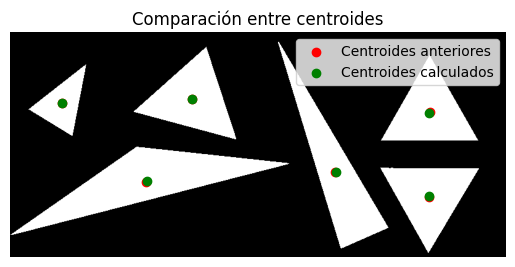

In [118]:
plt.imshow(bw_norm, cmap = "gray")
plt.scatter(df['Centroid_Col'], df['Centroid_Row'], c = 'r', label = "Centroides anteriores")
plt.scatter(df['Calculated_Centroid_Col'], df['Calculated_Centroid_Row'], c = 'g', label = "Centroides calculados")
plt.title("Comparación entre centroides")
plt.axis('off')
plt.savefig("comparacion", bbox_inches = "tight", pad_inches = 0)
plt.legend()
plt.show()